# Spectral Regularisation
Approach and Model in accordance with Nassar et al.

In [1]:
%load_ext autoreload
%autoreload 2

import math
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from pathlib import Path
from context import LocalLearning
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
import os
import copy
from scipy import stats

plt.style.use(['seaborn-paper', "./PRLDoubleCol.mplstyle"])

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Define and Train the Model

In [30]:
# Hyper Parameters
BATCH_SIZE = 1000
LEARNING_RATE = 1e-4
NUMBER_OF_EPOCHS = 1000

In [4]:
class Model(nn.Module):
    
    pSet = {
        "hidden": 2000,
    }
    
    def hidden(x: torch.Tensor):
        pass

class SpecRegModel(Model):
    
    # default parameters
    pSet = {
        "in_size": 32*32*3,
        "hidden_size": 2000,
        "p": 4.5,
        "no_classes": 10,
        "tau": 10, # regularizing cutoff
    }
    
    def __init__(self, params: dict=None, sigma: float=None, dtype: torch.dtype=torch.float32, **kwargs):
        super(SpecRegModel, self).__init__()
        if type(params) != type(None):
            self.pSet["in_size"] = params["in_size"]
            self.pSet["hidden_size"] = params["hidden_size"]
            self.pSet["p"] = params["p"]
            self.pSet["no_classes"] = params["no_classes"]
            self.pSet["tau"] = params["tau"]
            
        self.dtype = dtype
        self.flatten = nn.Flatten()
        
        # define linear mapping between input and hidden layer
        # creating the representations
        # same fashion as in KHL3 for optimal control
        self.W = torch.zeros((self.pSet["in_size"], self.pSet["hidden_size"]), dtype=self.dtype)

        # if sigma not explicitely specified, use Glorot initialisation
        # scheme
        if type(sigma) == type(None):
            sigma = 1.0 / math.sqrt(self.pSet["in_size"] + self.pSet["hidden_size"])
        
        self.W.normal_(mean=0.0, std=sigma)
        self.W = nn.Parameter(self.W)
        
        self.ReLU = nn.ReLU()
        # define second mapping
        self.dense = nn.Linear(self.pSet["hidden_size"], self.pSet["no_classes"], bias=False)
        
    def hidden(self, x: torch.Tensor):
        x_flat = self.flatten(x)
        return x_flat @ self.W
        
    def forward(self, x: torch.Tensor):
        hidden = self.hidden(x)
        latent_activation = torch.pow(self.ReLU(hidden), self.pSet["p"])
        return self.dense(latent_activation), hidden

In [5]:
srmodel = SpecRegModel(sigma=1.0)
srmodel.to(device)
srmodel.train()

SpecRegModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (ReLU): ReLU()
  (dense): Linear(in_features=2000, out_features=10, bias=False)
)

In [6]:
def cov(
    dataloader: DataLoader, 
    model: Model, 
    device: torch.device, 
    dtype: torch.dtype=torch.float32,
):
    
    with torch.no_grad():
        
        noE = model.pSet["hidden_size"]
        
        # initialize stat tensors
        auto_corr = torch.zeros((noE, noE), device=device, dtype=dtype)
        mean = torch.zeros((noE,), device=device, dtype=dtype)
        pop_size = 0
        
        # shift K - estimate of the mean
        f, _ = next(iter(dataloader))
        K = f.mean()
        
        
        for x, _ in dataloader:
            pop_size += len(x)
            pred = model.hidden(x.to(device))
            data = pred - K
            auto_corr += data.T @ data
            mean += data.sum(axis=0, dtype=dtype)
                
        cov = auto_corr - mean[None].T @ mean[None] / pop_size
        cov /= pop_size - 1
        
        return cov.clone()

In [7]:
train_data = LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=True,
    transform=ToTensor(),
    p=srmodel.pSet["p"],
)

dataloader_train = LocalLearning.DeviceDataLoader(
    train_data,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True,
)

test_data = LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=False,
    transform=ToTensor(),
    p=srmodel.pSet["p"],
)

dataloader_test = LocalLearning.DeviceDataLoader(
    test_data,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
class TrainSpecReg():
    
    sPs = {
        "alpha_reg": 1.0,
        "beta": 5.0, # Nassar et al. : beta = {1, 2, 5}
        "tau": 10,
    }
    
    def __init__(self,
                 device: torch.device,
                 learning_rate=1e-4,
                 spectral_ps: sPs=sPs,
                 no_epochs: int=5,
                 K: float=0.02,
                 dtype: torch.dtype=torch.float32,
                ):
        self.no_epochs = no_epochs
        self.K = K
        self.sPs = spectral_ps
        self.gamma = torch.Tensor()
        self.device = device
        self.dtype = dtype
        self.loss_history = []
        self.acc_history = []
        self.learning_rate = learning_rate
    
    def __call__(self, 
                 trainData: DataLoader,
                 model: SpecRegModel,
                 no_epochs: int=5,
                 testData: DataLoader=None,
                ):
        
        optimizer = Adam(model.parameters(), lr=self.learning_rate)
        ce_loss = CrossEntropyLoss()
        
        n = torch.arange(1, model.pSet["hidden_size"] + 1, device=self.device, dtype=self.dtype)
        self.gamma = n**(-self.sPs["beta"])
        
        def R_spec(lambda_n: torch.Tensor) -> torch.Tensor:
            gamma0 = lambda_n[0]
            tau = self.sPs["tau"]
            fractional_dev = (lambda_n / self.gamma) - 1.0
            res = fractional_dev[tau:]**2 + torch.maximum(
                    fractional_dev[tau:], torch.zeros((1,), device=self.device, dtype=self.dtype )
                )
            return self.sPs["beta"]*res.sum() / model.pSet["hidden_size"]
    
        with tqdm(range(1, no_epochs + 1), unit="epoch") as tepoch:
            tepoch.set_description(f"Training time [epochs]")
            
            for epoch in tepoch:

                # for each epoch, estimate the basis vectors of the
                # covariance matrix to diagonalize it
                Cxx = cov(trainData, model, device=device, dtype=torch.float64)
                lambda_n, S = torch.linalg.eigh(Cxx)
                _, idxs = torch.sort(lambda_n, descending=True)
                S = S[:, idxs] # sorted eigenvectors

                cumm_loss = 0.0
                model.train()
                for batch_nr, (features, labels) in enumerate(trainData):

                    pred, hidden_state = model(features.to(device))

                    # calculate the batch-wise covariance matrix
                    pop_size = len(features)
                    noE = model.pSet["hidden_size"]
                    hidden_state = hidden_state - self.K
                    auto_corr = torch.zeros((noE, noE), device=device, dtype=torch.float64)
                    auto_corr = hidden_state.T @ hidden_state
                    mean = hidden_state.mean(axis=0, dtype=torch.float64)

                    cxx = auto_corr - mean[None].T @ mean[None] / pop_size
                    cxx /= pop_size - 1

                    # calculate approximate diagonal elements based on 
                    diag = S.conj().T @ cxx @ S
                    approx_lambda_n = torch.diagonal(diag, 0)

                    labels = labels.to(torch.long)
                    loss = ce_loss(pred, labels.to(self.device)) + R_spec(approx_lambda_n)
                    cumm_loss += loss
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                self.loss_history.append(cumm_loss)
                
                if type(testData) != type(None):
                    freq_correct = 0
                    model.eval()
                    for batch_no, (features, labels) in enumerate(testData):
                        preds, _ = model(features.to(self.device))
                        preds = torch.argmax(preds, dim=-1)
                        freq_correct += (torch.abs(preds - labels.to(self.device)) == 0).sum()
            
                    self.acc_history.append(freq_correct / (len(testData)*testData.batch_size))
            
    def get_loss_history(self, mode: str="list"):
        if mode == "numpy":
            return np.array([loss.detach().cpu().numpy() for loss in self.loss_history])
        
        if mode == "torch":
            return torch.Tensor([loss.detach().cpu() for loss in self.loss_history])
        
        return self.loss_history
    
    def get_acc_history(self, mode: str="list"):
        if mode == "numpy":
            return np.array([loss.detach().cpu().numpy() for loss in self.acc_history])
        
        if mode == "torch":
            return torch.Tensor([loss.detach().cpu() for loss in self.acc_history])
        
        return self.acc_history

In [ ]:
spectral_model_parameter = TrainSpecReg.sPs
spectral_model_parameter["beta"] = 1.0
spectral_model_parameter["tau"] = 0
trainSpecReg = TrainSpecReg(device, learning_rate=LEARNING_RATE, spectral_ps=spectral_model_parameter)
trainSpecReg(dataloader_train, srmodel, no_epochs=NUMBER_OF_EPOCHS, testData=dataloader_test)

  0%|          | 0/1000 [00:00<?, ?epoch/s]

In [ ]:
# save the model
torch.save(
    {
        "SpecRegModel-path": str(llmodels_path / model_file),
        "SpecRegModel-state": ll_trained_state,
        "model_state_dict": khmodel.state_dict(),
        "loss_history": loss_history,
        "accuracy_history": accuracy_history,
    },
    llmodels_path.parent / Path("KHModelCIFAR10_ensemble") / Path("KHModel_" + str(model_file)),
)

In [32]:
srmodel.eval()
cxx = cov(dataloader_test, srmodel, device)
lambda_n, _ = torch.linalg.eigh(cxx)
lambda_sorted, _ = torch.sort(lambda_n, descending=True)
lambda_numpy = lambda_sorted.detach().cpu().numpy()

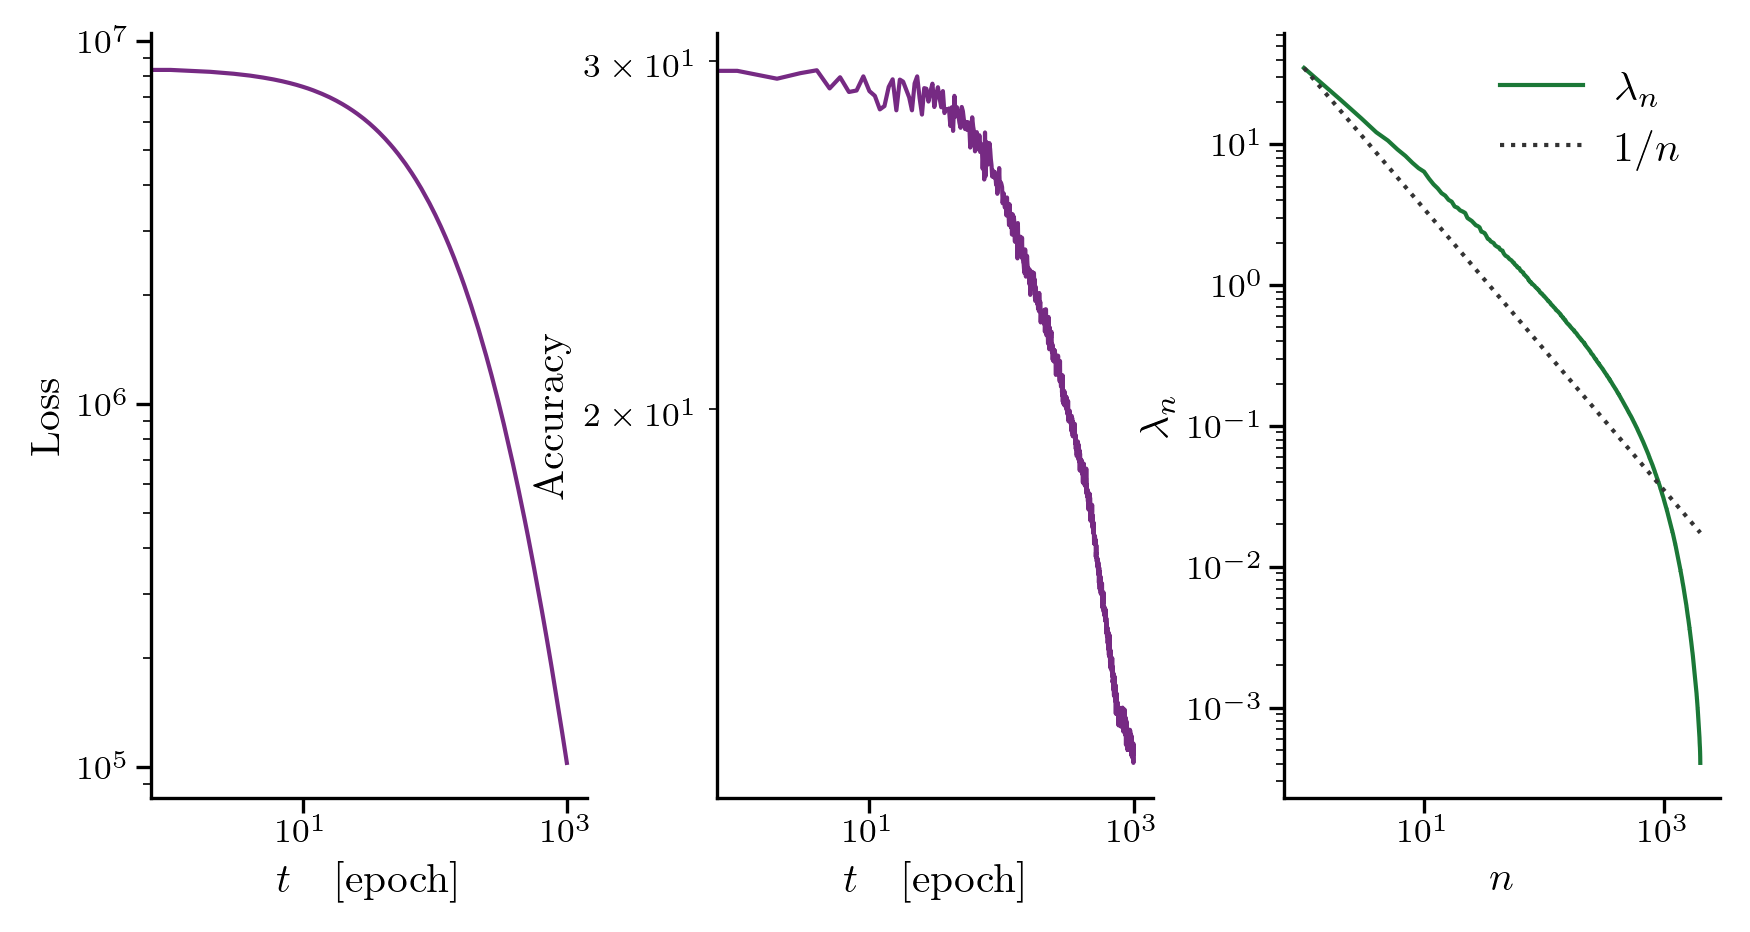

In [33]:
fig, axs = plt.subplots(1, 3)
n = np.arange(1, len(lambda_numpy)+1)
axs[0].loglog(trainSpecReg.get_loss_history(mode="numpy"), color='#762a83')
axs[0].set_xlabel(r"$t \quad [\textrm{epoch}]$")
axs[0].set_ylabel(r"Loss")

axs[1].loglog(100*trainSpecReg.get_acc_history(mode="numpy"), color='#762a83')
axs[1].set_xlabel(r"$t \quad [\textrm{epoch}]$")
axs[1].set_ylabel(r"Accuracy")

spec_line = axs[2].loglog(n, lambda_numpy, color='#1b7837')
norm_line = axs[2].loglog(n, lambda_numpy[0] / n, color='#333333', linestyle=":")
axs[2].set_xlabel(r"$n$")
axs[2].set_ylabel(r"$\lambda_{n}$")
axs[2].legend([r"$\lambda_{n}$", r"$1/n$"])
plt.show()